Computes Atmospheric Energy Transport (AET) and its components of Dry Static Energy Transport (DSE) and Latent Energy Transport (LET)

Computed from flux imbalances and ocean heat transport

This script has been verified to run with the NPL 2024a environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

from matplotlib.axes import Axes
from matplotlib.patches import Polygon
from cartopy.mpl.geoaxes import GeoAxes

In [2]:
student = ["CMIP6","aydenvdb","CMIP6","rnbarr1","nwharton","congdong","ericmei","jaypillai","geraint","lnzhang","adhall","skygale","smheflin"]

# Fully Coupled 
ddir = '/glade/derecho/scratch/bitz/ADF/climo/FullyCoupled/'  # this is where the climatologies are

casenames = ["b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001",
            "DoubleCO2",
            "b.e21.BCO2x4.f19_g17.CMIP6-abrupt4xCO2-2deg.001",
            "AlotofCH4",
            "RaiseSolar",
            "LowerSolar",
            "DirtyAir",
            "IcyNA",
            "DarkIce",
            "NoTrees",
            "FlatTibet",
            "FlatAntarctica",
            "FlatRockies"]

# this is what they were meant to be named
prefernames = ["piControl",
            "DoubleCO2",
            "QuadrupleCO2",
            "AlotofCH4",
            "RaiseSolar",
            "LowerSolar",
            "DirtyAir",
            "IcyNA",
            "DarkSeaIce",
            "NoTrees",
            "FlatTibet",
            "FlatTibet-Antarctica",
            "FlatTibet-Antarctica-Rockies"]

In [3]:
# get Gaussian Weights, gw, from any old cam hist file, a bit slow, sorry
gw=xr.open_dataset('/glade/derecho/scratch/bitz/archive/AMIPpiControl/atm/hist/AMIPpiControl.cam.h0.0001-01.nc').gw
weights = gw*0.5 # cosine weights times latitude spacing

def compute_global(da,gw): # multiply by so-called Gaussian weights that oddly enough sum to 2
    globalmean=(da*gw).sum(dim='lat')/2
    return globalmean

In [4]:
def ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,thevar):  # combine the fields for one variable into a nice xarray DataArray CAM variables
    x_all=[]
    for i,casename in enumerate(casenames):
        ncfile=ddir+casename+'_'+thevar+'_climo.nc'
        x=xr.open_dataset(ncfile)[thevar]
        x=x.mean(dim='lon') 
        x = x.assign_coords(casename=prefernames[i])
        x = x.expand_dims('casename')
        x['time'] = np.arange(1,13) # fix some of my times
        x.name=thevar
        x_all.append(x)
    x_all=xr.concat(x_all, "casename")
    x_all
    return x_all

def NHEATZonalMeanCombineFieldNicely(ddir,casenames,prefernames,thevar):  # combine the fields for one variable into a nice xarray DataArray POP N_HEAT
    x_all=[]
    for i,casename in enumerate(casenames):
        ncfile=ddir+casename+'_'+thevar+'_climo.nc'
        x=xr.open_dataset(ncfile)[thevar].isel(transport_comp=0).isel(transport_reg=0)  # get the total component and global region
        x = x.assign_coords(casename=prefernames[i])
        x = x.expand_dims('casename')
        x['time'] = np.arange(1,13) # fix some of my times
        x.name=thevar
        x_all.append(x)
    x_all=xr.concat(x_all, "casename")
    x_all
    return x_all


In [5]:
R_e = 6.371e6 # earth rad
Area_e = 4*np.pi*R_e*R_e
rho = 1000.
latice=3.337e5 # J/kg
latvap=2.501e6 #J/kg

In [6]:
precl=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'PRECL')
precc=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'PRECC')
prect=precl+precc
prect.name='prect'

In [7]:
precsl=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'PRECSL')
precsc=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'PRECSC')
snowt=rho*latice*(precsl+precsc)
snowt.name='snowt'

In [8]:
flnt=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'FLNT')
fsnt=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'FSNT')
TOMimbalance=fsnt-flnt
TOMimbalance.name='TOMimbalance'
TOMglobs=compute_global(TOMimbalance.mean(dim='time'),gw) # global imbalances in W m2
print(TOMglobs) # only first one for piControl should be zero

<xarray.DataArray (casename: 13)>
array([-1.17652190e-03,  2.04733923e+00,  3.30357838e+00,  1.30126061e+00,
        2.90531276e+00, -1.89242138e+00, -4.66204166e-03,  2.10485449e-01,
        9.39038926e-01,  1.77864446e-01,  7.50250519e-01,  9.88480111e-01,
        1.05528577e+00])
Coordinates:
  * casename  (casename) <U28 'piControl' ... 'FlatTibet-Antarctica-Rockies'


In [9]:
flns=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'FLNS')
fsns=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'FSNS')
lhflx=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'LHFLX')
shflx=ZonalMeanCombineFieldNicely(ddir,casenames,prefernames,'SHFLX')
SURFimbalance = fsns - flns - lhflx - shflx - snowt # yep snow is part of the surface energy balance
SURFimbalance.name = 'SURFimbalance' 
SURFglobs=compute_global(SURFimbalance.mean(dim='time'),gw) # global imbalances in W m2
print(SURFglobs) # only first one for piControl should be zero

<xarray.DataArray (casename: 13)>
array([-0.01762511,  2.05248617,  3.25246562,  1.28571737,  2.95704334,
       -1.93807979, -0.0088625 ,  0.18466717,  0.94192772,  0.11342321,
        0.74042984,  0.995854  ,  0.99975196])
Coordinates:
  * casename  (casename) <U28 'piControl' ... 'FlatTibet-Antarctica-Rockies'


In [10]:
condensation = rho*prect*latvap 
condensation.name = 'condensation'

# Atmosphere Energy Transport
Rnet_weighted = (TOMimbalance - SURFimbalance)*weights  # weights are cosine weights sort of
AET = Rnet_weighted.cumsum(dim='lat') * Area_e * 1e-15 # units are in PW
AET.name='AET'

# Latent Energy Transport or Moist Heat Tranport
Latent_weighted = (lhflx - condensation)*weights
LET = Latent_weighted.cumsum(dim='lat') * Area_e * 1e-15 # units are in PW
LET.name='LET'

#  Dry Static Energy Tranport
DSE=AET-LET  
DSE.name='DSE'

In [11]:
# Ocean Heat Transport, could compute from SURFimmbalance
ocnddir = '/glade/derecho/scratch/bitz/ATMS559HW3classruns/OceanClimos/'
thevar = 'N_HEAT'
OETauxgrid=NHEATZonalMeanCombineFieldNicely(ocnddir,casenames,prefernames,thevar) # this is on the POP auxilary latitudes grid, not the same as CAMs unfortunately
OET=OETauxgrid.interp(lat_aux_grid=AET.lat) # regrid to CAMs latitudes, nice and easy
OET.name='OET'

Text(0, 0.5, 'PW')

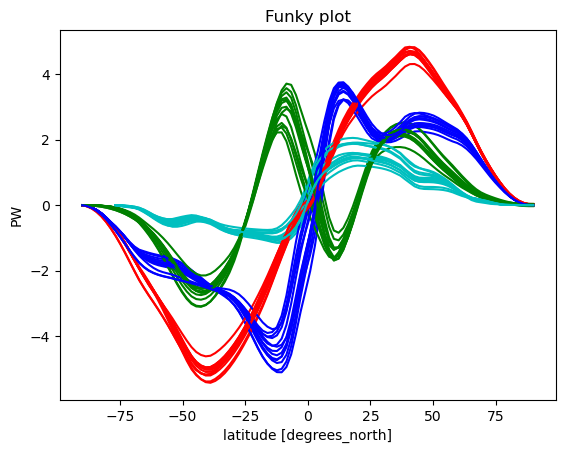

In [12]:
# it is good to see the transport near zero at the poles, sign that the total TOM minus SURF imbalances is pretty small
# however because the SURFimbalance by itself is not globally summing to zero, we can't use SURFimbalance to compute OET
# and must get it from the ocean model transport, which we just did
for casename in AET.casename:
    AET.sel(casename=casename).mean(dim='time').plot(color='r')
    LET.sel(casename=casename).mean(dim='time').plot(color='g')
    DSE.sel(casename=casename).mean(dim='time').plot(color='b')
    OET.sel(casename=casename).mean(dim='time').plot(color='c')

plt.title('Funky plot')
plt.ylabel('PW')

In [13]:
# plotting and averaging functions
def zonal1D(field, ax, title='',label=''):
    field.mean(dim='time').plot(ax=ax,label=label)
    ax.set_xticks(np.arange(-90, 120, 30))
    ax.set_title(title)
    ax.set_xticklabels(['90S','60S','30S','0','30N','60N','90N'])
    ax.set_xlabel('Latitude')

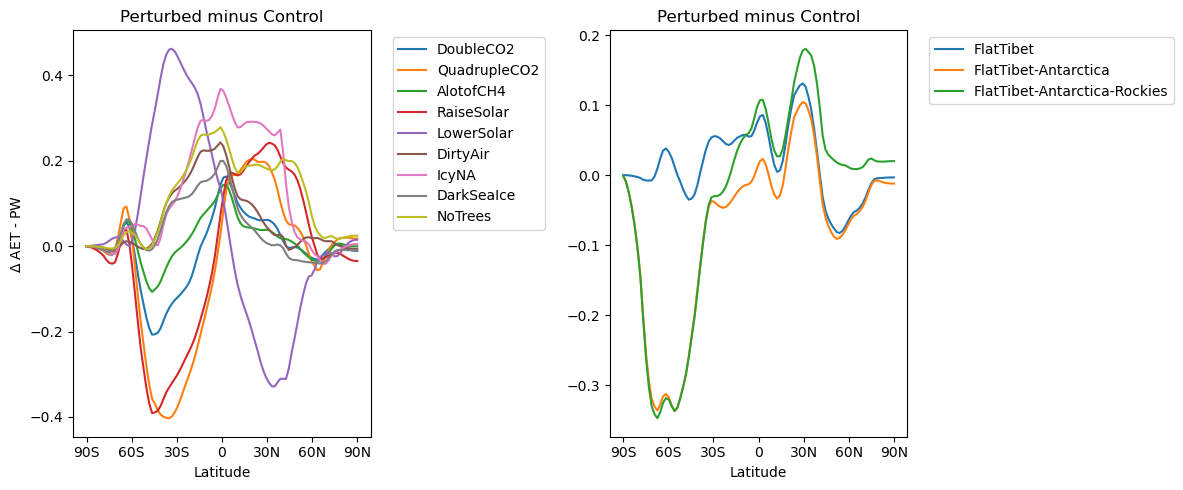

In [14]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 5) )
for i,casename in enumerate(AET.casename[1:10]):
    field = AET.sel(casename=casename)-AET.sel(casename='piControl')
    zonal1D(field, ax1, title='',label=casename.values) # convert m/s to cm/day
ax1.set_ylabel('$\Delta$ AET - PW')   
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.set_title('Perturbed minus Control' )

for i,casename in enumerate(AET.casename[10:13]):
    field = AET.sel(casename=casename)-AET.sel(casename='piControl')
    zonal1D(field, ax2, title='',label=casename.values) # convert m/s to cm/day
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.set_title('Perturbed minus Control' )

fig.tight_layout()

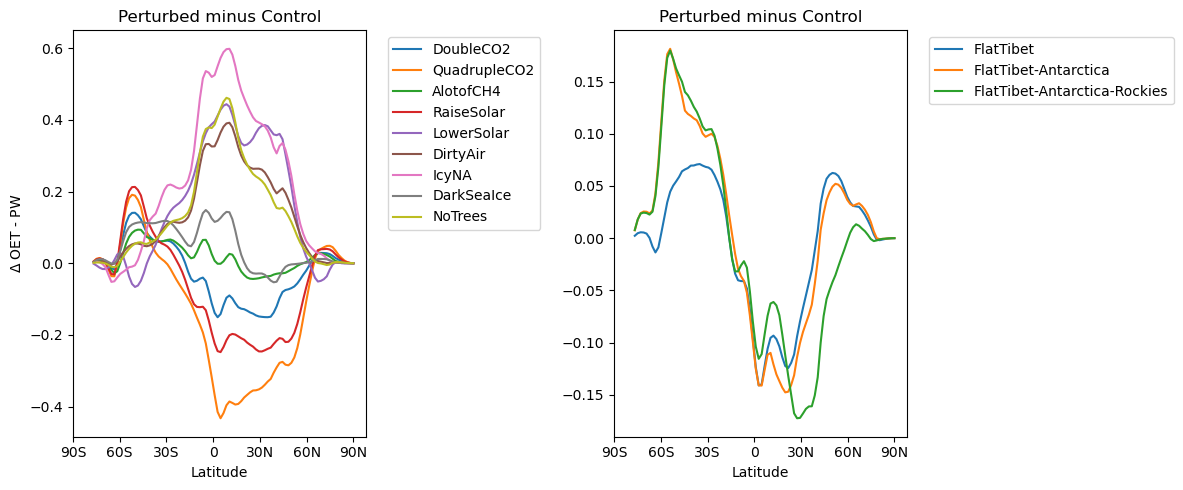

In [15]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 5) )
for i,casename in enumerate(AET.casename[1:10]):
    field = OET.sel(casename=casename)-OET.sel(casename='piControl')
    zonal1D(field, ax1, title='',label=casename.values) # convert m/s to cm/day
ax1.set_ylabel('$\Delta$ OET - PW')   
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.set_title('Perturbed minus Control' )

for i,casename in enumerate(AET.casename[10:13]):
    field = OET.sel(casename=casename)-OET.sel(casename='piControl')
    zonal1D(field, ax2, title='',label=casename.values) # convert m/s to cm/day
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.set_title('Perturbed minus Control' )

fig.tight_layout()

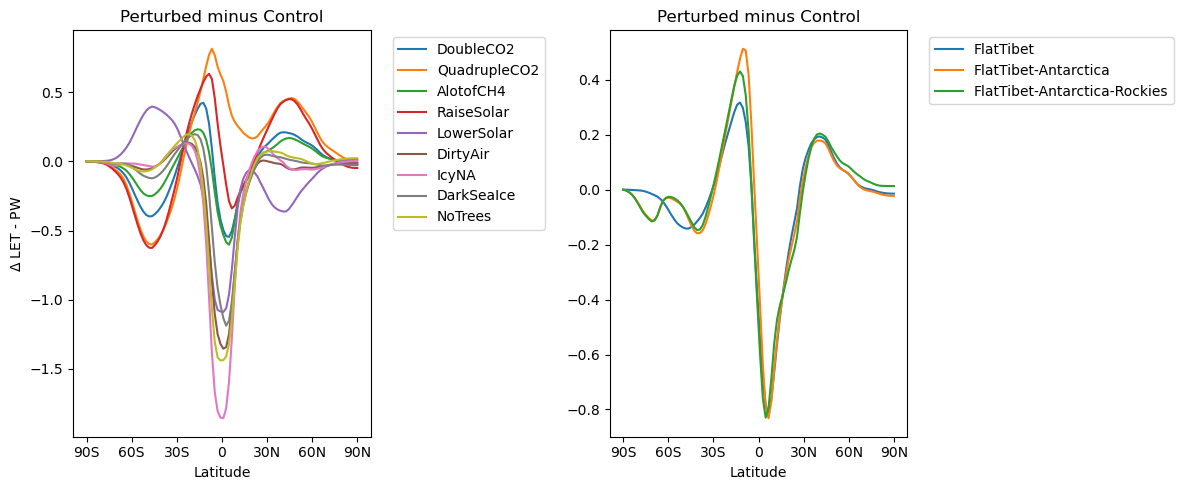

In [16]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 5) )
for i,casename in enumerate(AET.casename[1:10]):
    field = LET.sel(casename=casename)-LET.sel(casename='piControl')
    zonal1D(field, ax1, title='',label=casename.values) # convert m/s to cm/day
ax1.set_ylabel('$\Delta$ LET - PW')   
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.set_title('Perturbed minus Control' )

for i,casename in enumerate(AET.casename[10:13]):
    field = LET.sel(casename=casename)-LET.sel(casename='piControl')
    zonal1D(field, ax2, title='',label=casename.values) # convert m/s to cm/day
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.set_title('Perturbed minus Control' )

fig.tight_layout()

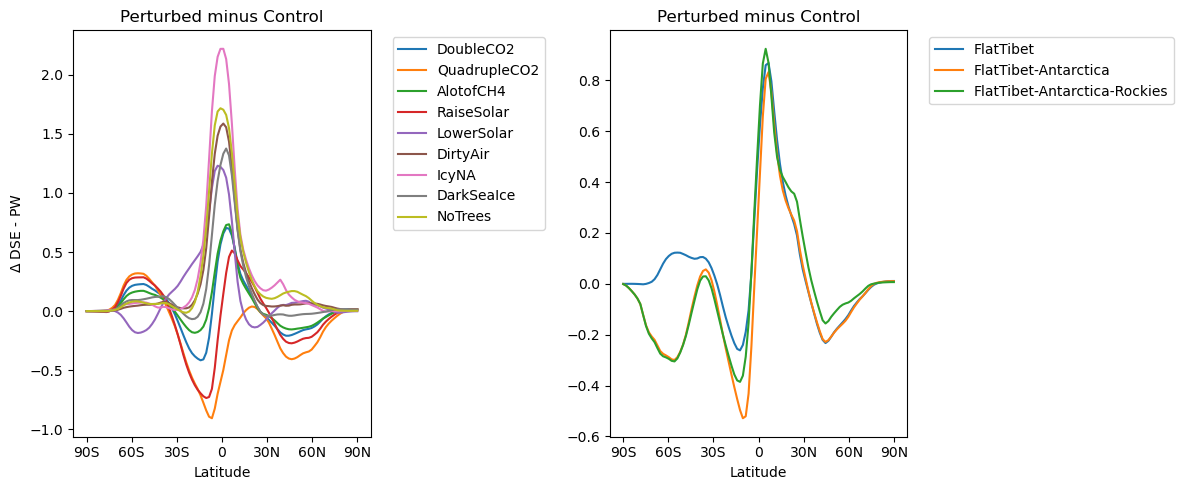

In [17]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 5) )
for i,casename in enumerate(AET.casename[1:10]):
    field = DSE.sel(casename=casename)-DSE.sel(casename='piControl')
    zonal1D(field, ax1, title='',label=casename.values) # convert m/s to cm/day
ax1.set_ylabel('$\Delta$ DSE - PW')   
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.set_title('Perturbed minus Control' )

for i,casename in enumerate(AET.casename[10:13]):
    field = DSE.sel(casename=casename)-DSE.sel(casename='piControl')
    zonal1D(field, ax2, title='',label=casename.values) # convert m/s to cm/day
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.set_title('Perturbed minus Control' )

fig.tight_layout()